OBJ:
* Demo smooth pipeline for complete ML model.

In [1]:
import pandas as pd
import numpy as np

## Load data

In [2]:
from src.data.io import import_and_prep_target_df_from_pickle, import_and_merge_feature_dfs_from_pickles

In [3]:
df = import_and_prep_target_df_from_pickle('./../../../data/interim/D3_dailyTS/EDdaily_occupancy_class15_clipped.pkl')

df.head()

,flag_target,EDMeanOcc_prevday
dt_date,,
2011-09-01,0,NaN
2011-09-02,0,27.375000
2011-09-03,1,27.291667
2011-09-04,1,43.375000
2011-09-05,0,50.083333


In [4]:
df.shape

(2587, 2)

In [5]:
pickle_features_list = ['callender.pkl', 'EDmorn.pkl', 'IPmorn.pkl', 'IPprevday_summary.pkl', 'EDprevday_summary.pkl']
df2 = import_and_merge_feature_dfs_from_pickles('./../../../data/interim/D3_dailyTS/', pickle_features_list, df)
df2.head()

,flag_target,EDMeanOcc_prevday,year,month,holiday,christmas_period,Friday,Monday,Saturday,Sunday,...,IPDAILYpatients_total,IPDAILYpatients_nonelec,IPDAILYpatients_elec,IPDAILYpatients_daycase,IPDAILYage_mean_elecnonelec,IPDAILYage_75plus_elecnonelec,EDDAILYattendances,EDDAILYadmissions,EDDAILYage_mean,EDDAILYage_75plus
dt_date,,,,,,,,,,,,,,,,,,,,,
2011-09-01,0,NaN,2011,9,0,0,0.0,0.0,0.0,0.0,...,1467,941,280,246,57.0552,443,247,92,38.2834,32
2011-09-02,0,27.375000,2011,9,0,0,1.0,0.0,0.0,0.0,...,1506,947,297,262,57.2942,446,261,115,41.0958,35
2011-09-03,1,27.291667,2011,9,0,0,0.0,0.0,1.0,0.0,...,1437,941,277,219,57.1113,437,261,111,41.7126,40
2011-09-04,1,43.375000,2011,9,0,0,0.0,0.0,0.0,1.0,...,1168,910,200,58,59.3313,418,310,133,40.3387,43
2011-09-05,0,50.083333,2011,9,0,0,0.0,1.0,0.0,0.0,...,1142,905,186,51,59.042,415,337,131,39.8754,44


In [6]:
for i in df2:
    print(i)

flag_target
EDMeanOcc_prevday
year
month
holiday
christmas_period
Friday
Monday
Saturday
Sunday
Thursday
Tuesday
Wednesday
EDMORNoccupancy
EDMORNage_mean
EDMORNage_75plus
IPMORNpatients_total
IPMORNpatients_nonelec
IPMORNpatients_elec
IPMORNpatients_daycase
IPMORNage_mean_elecnonelec
IPMORNage_75plus_elecnonelec
IPMORNwardmoves_mean_elecnonelec
IPMORNpatients_elecnonelec_gp
IPMORNpatients_elecnonelec_ed
IPDAILYpatients_total
IPDAILYpatients_nonelec
IPDAILYpatients_elec
IPDAILYpatients_daycase
IPDAILYage_mean_elecnonelec
IPDAILYage_75plus_elecnonelec
EDDAILYattendances
EDDAILYadmissions
EDDAILYage_mean
EDDAILYage_75plus


## Split data

In [7]:
from src.data.preprocess import make_timeseries_test_train_splits
X_train, X_test, y_train, y_test = make_timeseries_test_train_splits(df2, 'flag_target', 365)

DATA POINTS:
orig size 2587
training:  2222
testing:  365


## Prepare data

In [8]:
# version 19.2
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder 

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from src.data.preprocess import DataFrameSelector, DataFrameReform, MakeBooleanAnInteger

In [9]:
X_train.head(2)

,EDMeanOcc_prevday,year,month,holiday,christmas_period,Friday,Monday,Saturday,Sunday,Thursday,...,IPDAILYpatients_total,IPDAILYpatients_nonelec,IPDAILYpatients_elec,IPDAILYpatients_daycase,IPDAILYage_mean_elecnonelec,IPDAILYage_75plus_elecnonelec,EDDAILYattendances,EDDAILYadmissions,EDDAILYage_mean,EDDAILYage_75plus
dt_date,,,,,,,,,,,,,,,,,,,,,
2011-09-01,NaN,2011,9,0,0,0.0,0.0,0.0,0.0,1.0,...,1467,941,280,246,57.0552,443,247,92,38.2834,32
2011-09-02,27.375,2011,9,0,0,1.0,0.0,0.0,0.0,0.0,...,1506,947,297,262,57.2942,446,261,115,41.0958,35


In [10]:

bin_features = ['holiday','christmas_period','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
num_features = list(set(X_train.columns) - set(bin_features))
all_features = num_features + bin_features

In [11]:
#### make numerical and binary pipelines
num_pipeline = Pipeline([
    ('selector',DataFrameSelector(num_features)),
#     ('feature_filter',SelectKBest(f_classif,k='all')),
    ('imputer',SimpleImputer(strategy='median')),
    ('std_scaler',StandardScaler()),
])

bin_pipeline = Pipeline([
    ('selector',DataFrameSelector(bin_features)),
    ('boolean_conversion',MakeBooleanAnInteger()),
    ('imputer',SimpleImputer(strategy='most_frequent')),
])


pipes_type_list = [
    ('num_pipeline',num_pipeline),
  ('bin_pipeline',bin_pipeline),
]


#### define all parts of preprocessing in pipeline
preprocess_pipeline = make_pipeline(
    FeatureUnion(transformer_list=pipes_type_list),
    DataFrameReform(all_features)
)

#### call pipeline
X_trainT = preprocess_pipeline.fit_transform(X_train,y_train)
X_trainT.head()

,IPMORNwardmoves_mean_elecnonelec,EDMeanOcc_prevday,IPMORNpatients_elecnonelec_gp,EDDAILYadmissions,IPMORNage_mean_elecnonelec,EDMORNage_mean,IPMORNpatients_total,IPDAILYpatients_elec,EDDAILYage_mean,IPDAILYpatients_daycase,...,EDMORNage_75plus,holiday,christmas_period,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,-1.723995,-0.083565,0.293832,-2.631948,-1.605790,-1.538231,-1.689196,0.450067,-1.071971,0.252306,...,-1.592424,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.810567,-2.481070,0.613017,-1.171726,-1.849186,-1.955488,-1.335950,0.823031,0.183753,0.416639,...,-2.177617,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-1.680742,-2.492247,0.666215,-1.425678,-0.607783,-0.299036,-2.307377,0.384250,0.459179,-0.025007,...,-1.299828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.600841,-0.335051,0.293832,-0.028944,-0.744100,-2.065083,-2.458768,-1.305058,-0.154280,-1.678613,...,-1.885021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.735423,0.564712,0.347029,-0.155920,-0.154753,-0.715149,-2.055058,-1.612205,-0.361160,-1.750509,...,-2.177617,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model search

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, TimeSeriesSplit

In [13]:
classifier_pipeline = make_pipeline(
#     preprocess_pipeline,
    LogisticRegression(solver='liblinear',class_weight ='balanced')

)

In [14]:
param_grid = {
    'logisticregression__C':[0.01, 0.05, 0.1,0.2,0.3,0.5,0.7,1,3,10],
       'logisticregression__penalty':['l1','l2'],
    'logisticregression__class_weight':['balanced', None, {1: 10}, {1:3},{1:5}, {1: 20}],
       }

In [15]:
lgr_model = LogisticRegression(solver='liblinear',class_weight ='balanced')

In [16]:
param_grid = {
    'C':[0.01, 0.05, 0.1,0.2,0.3,0.5,0.7,1,3,10],
       'penalty':['l1','l2'],
#     'class_weight':['balanced', None, {1: 10}, {1:3},{1:5}, {1: 20}],
       }

In [17]:
tscv = TimeSeriesSplit(n_splits=6)

In [18]:
grid_search = GridSearchCV(lgr_model, param_grid, cv=tscv, scoring='average_precision', return_train_score=True)
# brier_score_loss, average_precision
grid_search.fit(X_trainT, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=6),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 3, 10],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='average_precision', verbose=0)

In [19]:
import sklearn

In [20]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [21]:
grid_search.best_estimator_

LogisticRegression(C=0.3, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
grid_search.best_params_

{'C': 0.3, 'penalty': 'l2'}

In [23]:
X_trainT.to_numpy()

array([[-1.7239953 , -0.08356477,  0.29383156, ...,  0.        ,
         0.        ,  0.        ],
       [-1.81056733, -2.48107014,  0.61301695, ...,  1.        ,
         0.        ,  0.        ],
       [-1.68074176, -2.49224732,  0.66621452, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.60414674,  0.60942046, -1.72767594, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.54087396,  0.84414127, -1.7808735 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.53217411, -0.16739363, -1.99366377, ...,  0.        ,
         1.        ,  0.        ]])

## Evaluation using CV on training set

In [24]:
from src.eval.eval_utils import cross_val_predict_tscv, ModelCVEvaluation

No handles with labels found to put in legend.


CV results
       average_precision  briers_score_loss
count           8.000000           8.000000
mean            0.630985           0.144235
std             0.088461           0.053077
min             0.523324           0.070205
25%             0.570787           0.113910
50%             0.606937           0.129630
75%             0.698156           0.188986
max             0.774909           0.219945


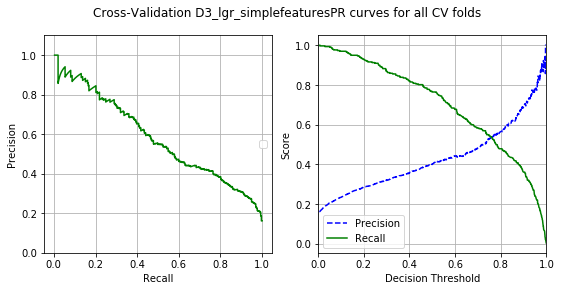

In [25]:
meval = ModelCVEvaluation(grid_search.best_estimator_, 'D3_lgr_simplefeatures', X_trainT, y_train, 8)

Look at each fold of Timseries:

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


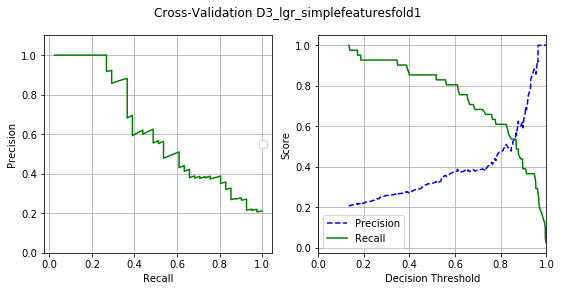

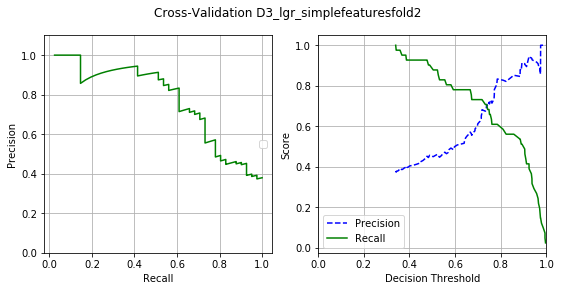

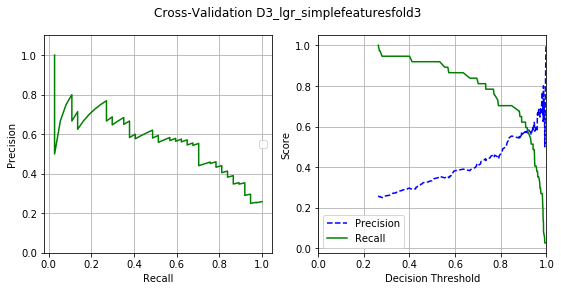

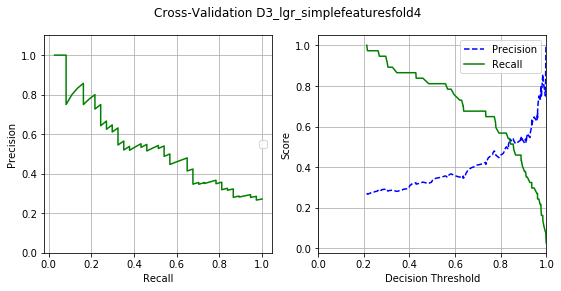

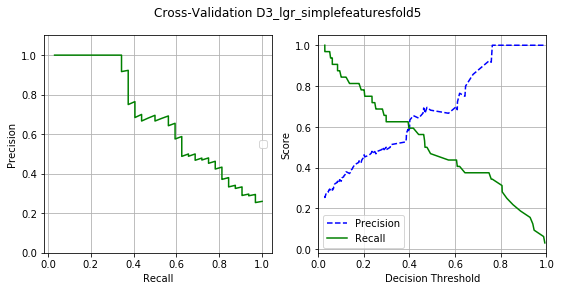

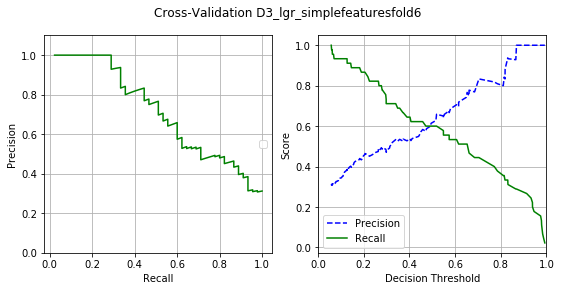

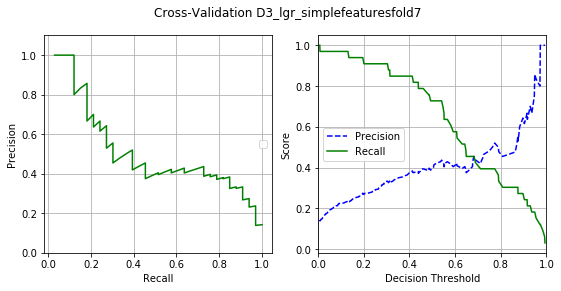

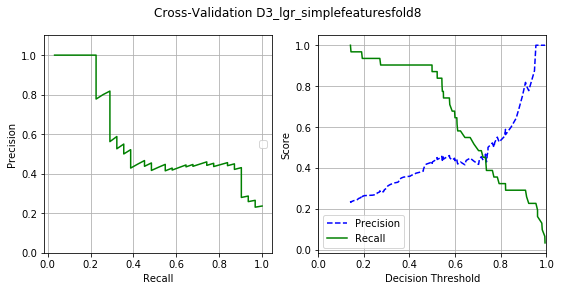

In [26]:
meval.plot_PR_curve_each_valid_set()